In [ ]:
!pip install newsapi-python

In [ ]:
!pip install transformers

In [ ]:
from newsapi import NewsApiClient
import pandas as pd
import re
import requests
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Google search URL
query = "bmw rebrand"
google_url = f"https://www.google.com/search?q={query.replace(' ', '+')}&num=30"

# Headers to mimic a browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Send request to Google
response = requests.get(google_url, headers=headers)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
    results = []

    # Parse search results
    for result in soup.find_all("div", class_="tF2Cxc"):
        title = result.find("h3").text if result.find("h3") else "No Title"
        link = result.find("a")["href"] if result.find("a") else "No URL"
        results.append({"Title": title, "URL": link})

    # Fetch descriptions and published times from each URL
    descriptions = []
    published_times = []
    for result in results:
        try:
            url = result["URL"]
            page_response = requests.get(url, headers=headers, timeout=5)
            page_soup = BeautifulSoup(page_response.text, "html.parser")

            # Try to get meta description or first paragraph
            meta_description = page_soup.find("meta", {"name": "description"})
            description = meta_description["content"] if meta_description else "No Meta Description"

            # Extract the publication time
            published_at = page_soup.find('meta', attrs={'property': 'article:published_time'})
            published_time = published_at["content"] if published_at else "No Published Time"

            descriptions.append(description)
            published_times.append(published_time)
        except Exception as e:
            descriptions.append("Failed to Fetch Description")
            published_times.append("Failed to Fetch Published Time")
            print(f"Failed to fetch description or published time for URL: {url}. Error: {e}")

        # Avoid getting blocked
        time.sleep(2)
    for i in range(len(descriptions)):
      if descriptions[i] == "No Meta Description":
          descriptions[i] = ""
    # Add descriptions and published times to results
    for i in range(len(results)):
        results[i]["Description"] = descriptions[i]
        results[i]["Published Time"] = published_times[i]

    # Convert to DataFrame
    df = pd.DataFrame(results)
    print(df)

else:
    print(f"Failed to fetch results. Status Code: {response.status_code}")


Failed to fetch description or published time for URL: https://www.bmw.com/en/automotive-life/bmw-logo-meaning-history1.html. Error: HTTPSConnectionPool(host='www.bmw.com', port=443): Read timed out. (read timeout=5)
Failed to fetch description or published time for URL: https://www.bmwgroup.com/en/company/transformation.html. Error: HTTPSConnectionPool(host='www.bmwgroup.com', port=443): Read timed out. (read timeout=5)
Failed to fetch description or published time for URL: https://www.bmw-m.com/en/topics/magazine-article-pool/die-geschichte-des-bmw-m-logos.html. Error: HTTPSConnectionPool(host='www.bmw-m.com', port=443): Read timed out. (read timeout=5)
                                                Title  \
0   BMW unveils flat logo in first rebrand for ......   
1   Is BMW's radical logo redesign the car rebrand...   
2   Introducing BMW's new brand design for online ...   
3   First BMWs Influenced By New Design Team Comin...   
4            BMW updates logo to mark a “new chapte

In [ ]:
# Fill missing values with an empty string
df.fillna("", inplace=True)


# Concatenate title, description, and content into a single column
df['text'] = df['Title'] + " " + df['Description']

# Remove duplicates based on the concatenated text
df.drop_duplicates(subset=['text'], inplace=True)

# Clean text: remove URLs, special characters, and multiple spaces
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

df['clean_text'] = df['text'].map(clean_text)


df.to_csv('bmw_preprocessed.csv', index=False)
print(df[['clean_text', 'Published Time']].head())


                                          clean_text  \
0  BMW unveils flat logo in first rebrand for Dez...   
1  Is BMWs radical logo redesign the car rebrand ...   
2  Introducing BMWs new brand design for online M...   
3  First BMWs Influenced By New Design Team Comin...   
4             BMW updates logo to mark a new chapter   

              Published Time  
0  2020-03-05T16:17:40+00:00  
1       2021-03-16T15:56:18Z  
2          No Published Time  
3  2024-09-14T06:50:26+00:00  
4          No Published Time  


In [ ]:
sentiment_analyzer = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment')

def analyze_sentiment_transformer(text):
    result = sentiment_analyzer(text[:512])
    sentiment = result[0]
    label_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}
    return label_map[sentiment['label']], sentiment['score']

df['sentiment'], df['sentiment_score'] = zip(*df['clean_text'].map(analyze_sentiment_transformer))

df.to_csv('bmw_sentiment.csv', index=False)

print(df[['clean_text', 'sentiment', 'sentiment_score']].head())


                                          clean_text sentiment  \
0  BMW unveils flat logo in first rebrand for Dez...   Neutral   
1  Is BMWs radical logo redesign the car rebrand ...   Neutral   
2  Introducing BMWs new brand design for online M...  Positive   
3  First BMWs Influenced By New Design Team Comin...   Neutral   
4             BMW updates logo to mark a new chapter   Neutral   

   sentiment_score  
0         0.521198  
1         0.793495  
2         0.814058  
3         0.655306  
4         0.666204  


<ipython-input-45-f55d3194247f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='coolwarm', order=['Negative', 'Neutral', 'Positive'])


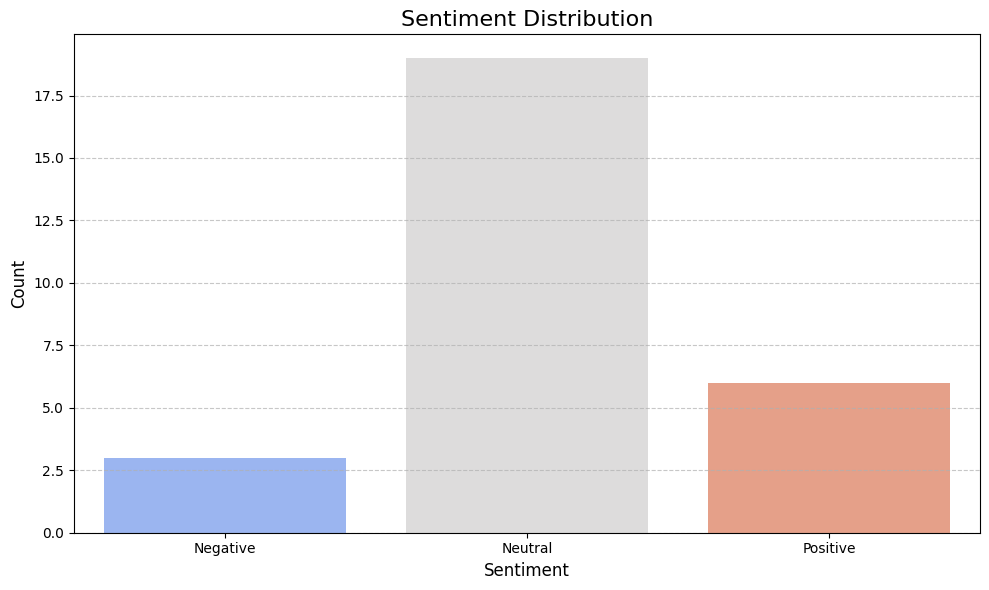

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', palette='coolwarm', order=['Negative', 'Neutral', 'Positive'])
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

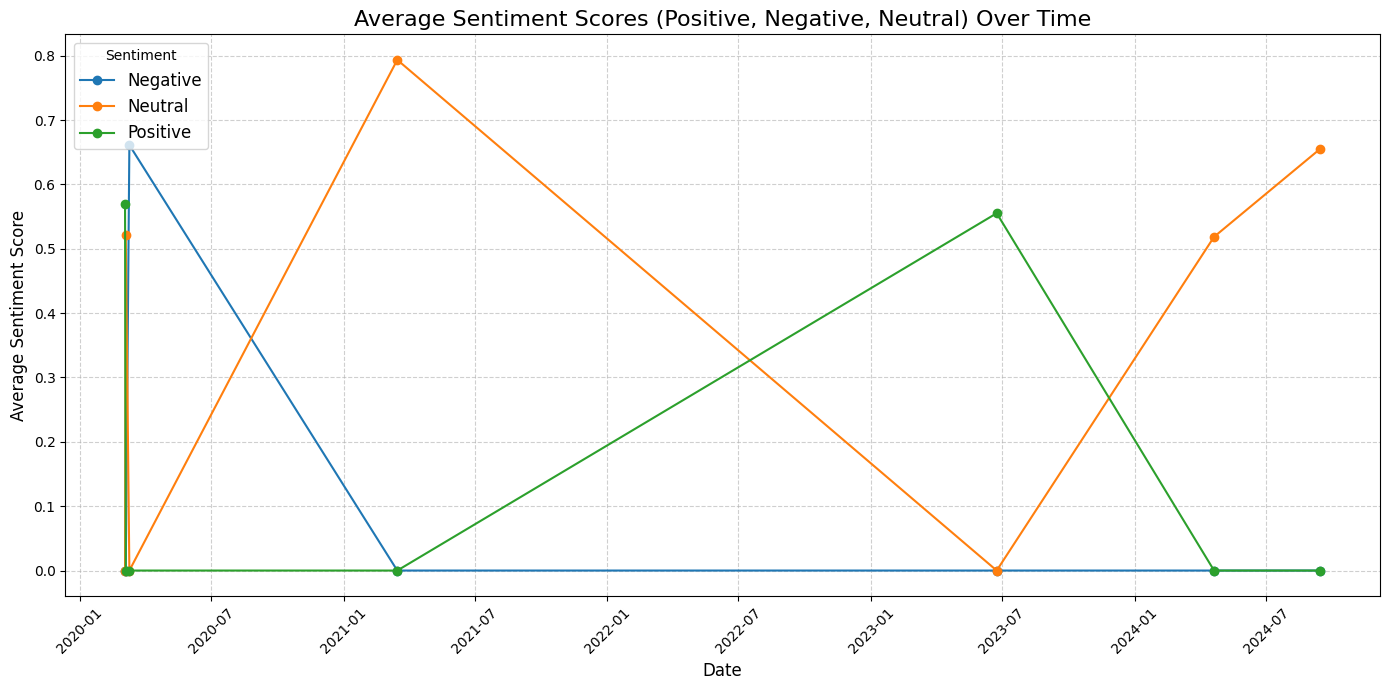

In [ ]:
df['date'] = pd.to_datetime(df['Published Time'], errors='coerce')


df['date'] = df['date'].dt.date

# Group by date and sentiment, and calculate the average sentiment score
average_sentiment_scores = df.groupby(['date', 'sentiment'])['sentiment_score'].mean().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
average_sentiment_scores.plot(kind='line', marker='o', linestyle='-', markersize=6, figsize=(14, 7))
plt.title('Average Sentiment Scores (Positive, Negative, Neutral) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Sentiment', loc='upper left', fontsize=12)
plt.show()


In [ ]:
emotion_analyzer = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base')

def analyze_emotion(text):
    result = emotion_analyzer(text[:512])
    emotion = result[0]
    return emotion['label'], emotion['score']

df['emotion'], df['emotion_score'] = zip(*df['clean_text'].map(analyze_emotion))

df.to_csv('bmw_emotion.csv', index=False)

print(df[['clean_text', 'emotion', 'emotion_score']].head())


                                          clean_text  emotion  emotion_score
0  BMW unveils flat logo in first rebrand for Dez...  neutral       0.802911
1  Is BMWs radical logo redesign the car rebrand ...  neutral       0.521566
2  Introducing BMWs new brand design for online M...  neutral       0.662781
3  First BMWs Influenced By New Design Team Comin...      joy       0.490308
4             BMW updates logo to mark a new chapter  neutral       0.686046


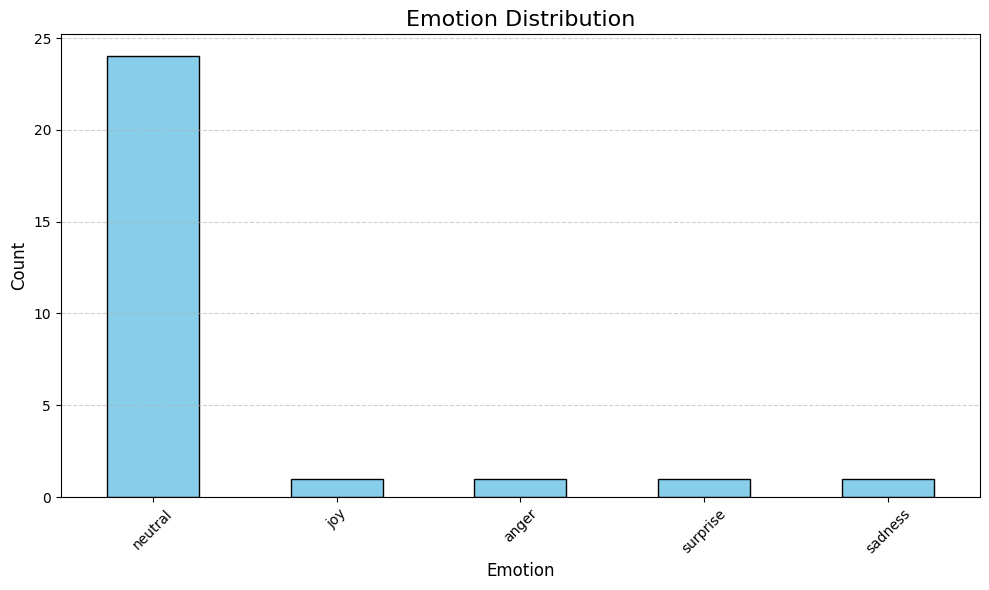

In [ ]:
emotion_counts = df['emotion'].value_counts()

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Emotion Distribution', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


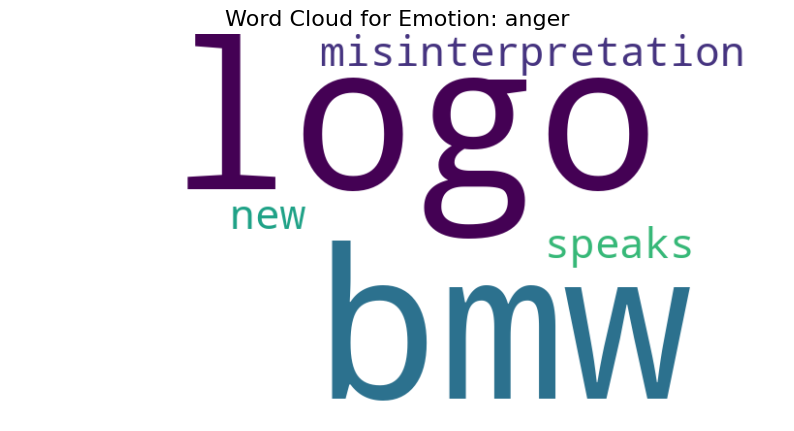

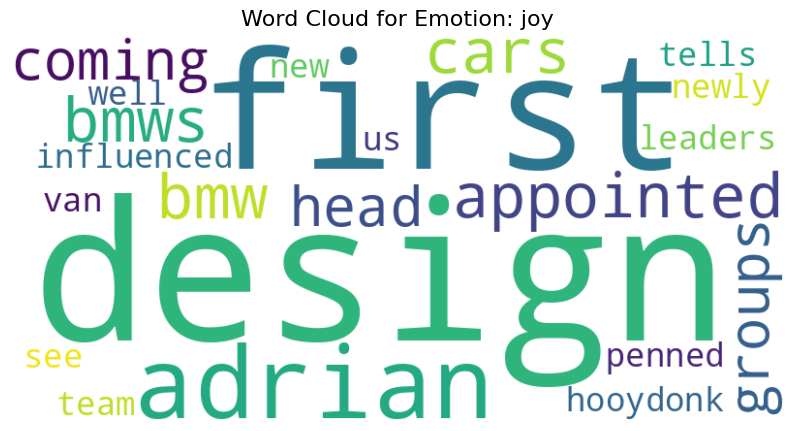

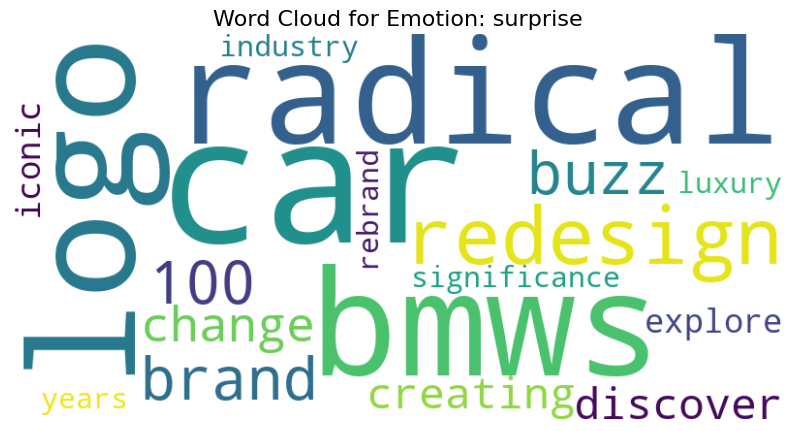

In [ ]:
# Download stopwords if not already available
import nltk
nltk.download('stopwords')

# Define a function to generate word cloud for a given emotion
def plot_wordcloud(emotion, text_data):
    # Set up the CountVectorizer to exclude stopwords
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    # Fit the vectorizer and transform the text
    X = vectorizer.fit_transform(text_data)
    # Sum up the word frequencies
    word_freq = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()

    # Create a dictionary of words and their frequencies
    word_freq_dict = dict(zip(words, word_freq))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Emotion: {emotion}", fontsize=16)
    plt.show()

# Filter the dataframe to exclude neutral emotions
filtered_emotions = df[df['emotion'] != 'neutral']

# Loop over each emotion and generate the word cloud
for emotion in ['anger', 'joy', 'surprise']:
    emotion_data = filtered_emotions[filtered_emotions['emotion'] == emotion]['clean_text']
    plot_wordcloud(emotion, emotion_data)


In [ ]:
# Function to get the most common bigrams for a given emotion
def extract_bigrams_by_emotion(df, emotion):
    # Filter the data for the specific emotion
    emotion_df = df[df['emotion'] == emotion]

    # Initialize vectorizer to capture common bigrams (pairs of words)
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")

    # Apply vectorizer to extract bigrams
    X = vectorizer.fit_transform(emotion_df['clean_text'])  # Ensure you are using the 'clean_text' column
    bigrams = vectorizer.get_feature_names_out()
    bigram_counts = X.toarray().sum(axis=0)

    # Create a DataFrame to store bigrams and their counts
    bigram_freq_df = pd.DataFrame({'Bigram': bigrams, 'Frequency': bigram_counts})
    bigram_freq_df = bigram_freq_df.sort_values(by='Frequency', ascending=False)

    return bigram_freq_df

# Extract and save the most common bigrams to separate CSV files for each emotion
emotions = ['anger', 'joy', 'sadness']

# Loop through each emotion and save the bigrams to a CSV
for emotion in emotions:
    # Extract bigrams for the current emotion
    bigram_freq_df = extract_bigrams_by_emotion(df, emotion)

    # Save the bigrams and their frequencies to a CSV file named after the emotion
    file_name = f'{emotion}_bigrams.csv'
    bigram_freq_df.to_csv(file_name, index=False)  # Save both 'Bigram' and 'Frequency' columns

    # Display the saved CSV content
    print(f"Displaying top bigrams for {emotion.capitalize()} from {file_name}:")
    print(bigram_freq_df.head(40))
    print("\n" + "-"*50 + "\n")


Displaying top bigrams for Anger from anger_bigrams.csv:
                     Bigram  Frequency
0                bmw speaks          1
1     misinterpretation new          1
2                  new logo          1
3  speaks misinterpretation          1

--------------------------------------------------

Displaying top bigrams for Joy from joy_bigrams.csv:
              Bigram  Frequency
0         adrian van          1
10       head design          1
17        tells cars          1
16       team coming          1
15      penned newly          1
14   newly appointed          1
13        new design          1
12    influenced new          1
11    hooydonk tells          1
9        groups head          1
1   appointed design          1
8        design team          1
7     design leaders          1
6      design adrian          1
5         coming bmw          1
4        cars penned          1
3    bmws influenced          1
2         bmw groups          1
18      van hooydonk          1

-

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# List of file paths for the CSV files
file_paths = [
    "/content/bmw_emotion.csv",
    "/content/sadness_bigrams.csv",
    "/content/joy_bigrams.csv",
    "/content/anger_bigrams.csv"
]

# Read CSV files
dataframes = [pd.read_csv(file) for file in file_paths]

# Combine the DataFrames
combined_df = pd.concat(dataframes, axis=1)  # Use axis=1 for column-wise or axis=0 for row-wise concatenation

# Save combined DataFrame to a new Excel file
combined_df.to_excel("combined_output.xlsx", index=False, engine='openpyxl')  # Ensure 'openpyxl' is installed

print("Data combined and saved to 'combined_output.xlsx'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data combined and saved to 'combined_output.xlsx'.


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at mrm8488/t5-base-finetuned-emotion and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-3f11d94004bf>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sentiment_labels, palette='coolwarm', order=['NEGATIVE', 'POSITIVE'])


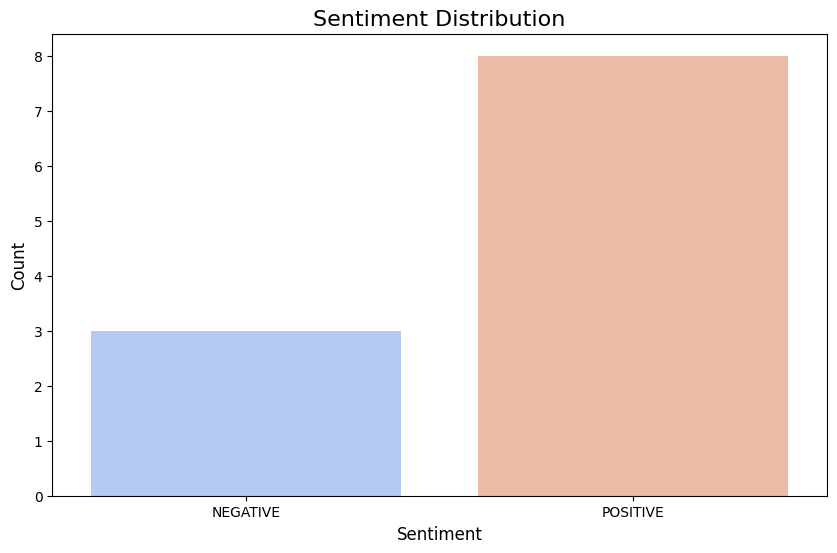

In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated audience responses
responses = [
    "This redesign truly embodies Jaguar's legacy while looking ahead. The emphasis on sustainability is inspiring.",
    "Finally, a luxury car brand taking inclusivity seriously—this feels modern and refreshing!",
    "The combination of innovation and luxury is spot on. Jaguar's future looks bright.",
    "I was skeptical about bright colors, but they blend beautifully without compromising Jaguar's premium feel.",
    "Using woke culture as part of the aesthetic shows boldness. It works well for a modern audience.",
    "It’s great to see bright colors used with such sophistication, maintaining Jaguar’s elegance.",
    "The way Jaguar ties its heritage to its vision of sustainability is brilliant.",
    "The logo change is not a good idea. ",
    "The rebranding might causes serious downfall",
    "Lot of people don't want Jaguar to go all-electric"
    "This rebrand isn’t just about cars; it’s about a movement towards excellence and responsibility.",
    "Jaguar’s storytelling gave me goosebumps—it’s a brand that knows where it came from and where it’s going."
]

# Load sentiment analysis pipeline
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Load emotion detection pipeline
emotion_classifier = pipeline("text-classification", model="mrm8488/t5-base-finetuned-emotion")

# Perform sentiment analysis
sentiments = classifier(responses)

# Perform emotion analysis
emotions = emotion_classifier(responses)

# Prepare data for plotting
sentiment_labels = [sentiment['label'] for sentiment in sentiments]


# Mapping sentiment labels to numerical values for plotting
sentiment_values = [1 if label == 'POSITIVE' else 0 for label in sentiment_labels]


# Set up the plot
plt.figure(figsize=(10, 6))

# Plot sentiment distribution
sns.countplot(x=sentiment_labels, palette='coolwarm', order=['NEGATIVE', 'POSITIVE'])
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

